### Spark Intro
Apache Spark is an open-source **multi-language engine** for large-scale data processing. Spark is an engine because the processing happends in Spark (not on data base side). There are many wrappers for Spark to use it using different programming languages (e.g. Python -> PySpark, R, Java, ...).

- Spark can be used for both streaming and batch jobs. 

### When to Use Spark?
Spark is usually applied on Data Lake (e.g. Amazon S3, GCP Storage, ...). It pulls that data, processes it and puts back into the Data Lake. If it's possible express your jobs using SQL, go with it and don't use Spark. However, if this is not the case, processing pipeline is complex and requires a complicated logic, use Spark! Simple case when your job cannot be expressed using SQL -> Machine Learning Models.

### How to Install Spark
The easiest way is to use Docker container. Manual setup is here: https://github.com/DataTalksClub/data-engineering-zoomcamp/tree/main/05-batch/setup

### Spark Cluster
Spark cluster is a **set of executors/workers** that pull the data from the data source (e.g. Data Lake). Number of workers depends on the tasks and can be easily customized. For faster data processing **it's recommended to partition the data** so that all workers are busy during data processing. If number of partitions is small, some workers might not take part in data processing at all and data processing will be inefficient. 

If the DataFrame or the data is not partitioned, use `spark.repartition()`. Repartitioning is expensive operation. If the resulting number of partitions is big (sparse), we can apply reverse operation. In PySpark it's called `spark.coalesce()`

When we define `SparkSession` and provide `local[*]`, it means that we are going to create local spark cluster with N number of *workers* and one *master*. Master is responsible for tasks controlling and resources managing whereas workers simply pull part of the data and do the job -> process it. For example, if a worker fails (i.e. not responsing/unavailable), master must reassign that job to a new worker. 

Besides, there is a driver that submits a job to a Spark master (e.g. local laptop, airflow task).

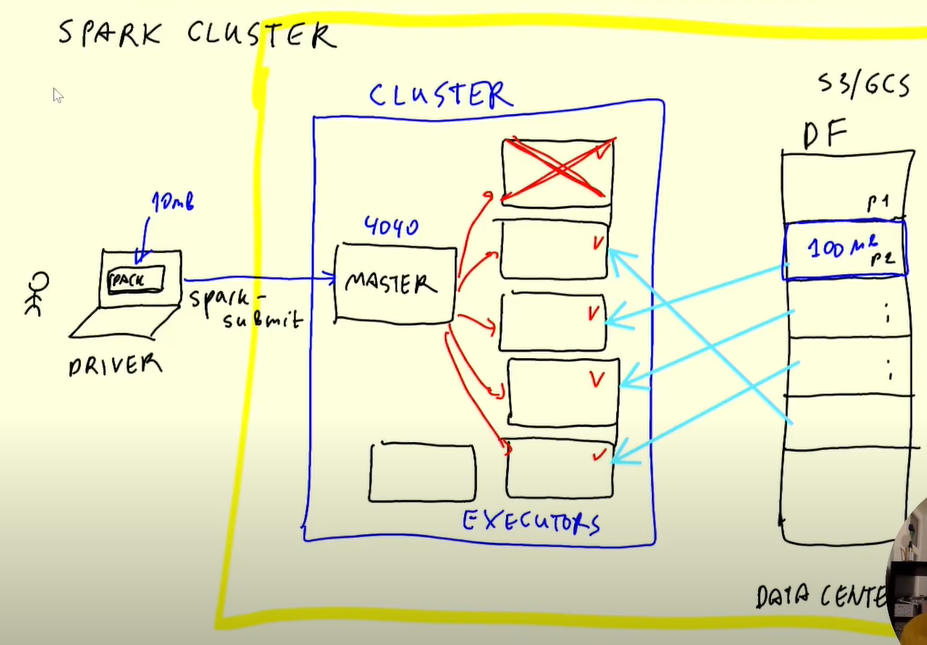

### Actions and Transformations
In Spark there are things that are executed right away and not right away. 

**Transformations**
- Columns selection, filtering, ...
- New columns creation, aggregations, joins, ...
- Lazy Execution

**Actions**
- `show()`, `head()`, `take()`, `write()`...
- Executed right away (eager)


### Spark Functions 
Spark has a list of predefined funtions. These functions can be accessed from `pyspark.sql.functions`. Use the following convention when importing functions from the module:
- `pyspark.sql import functions as F` 

However, not all predefined functions can tackle all the task. To define own custom functions we need to use `UDF - User Defined Functions`. 
```
def my_custom_functions():
    logic ...

my_custom_udf = F.udf(my_custom_functions, returnType=...)
```

- If we provide dir name instead of a file name, Spark reads all the data from that dir

### How Does Spark Implement GroupBy?
First, Spark workers apply filtering on the data and only then apply initial `groupBy`. Initial -> because a single executor can process a single partition at a time and it performs `groupBy` within that partition.
For each partition we have a bantch of temporary files that contain sub results. These subresults must be later combined and grouped again.   

Such grouping is usually done in 2 stages. Here is an example of the first stage:

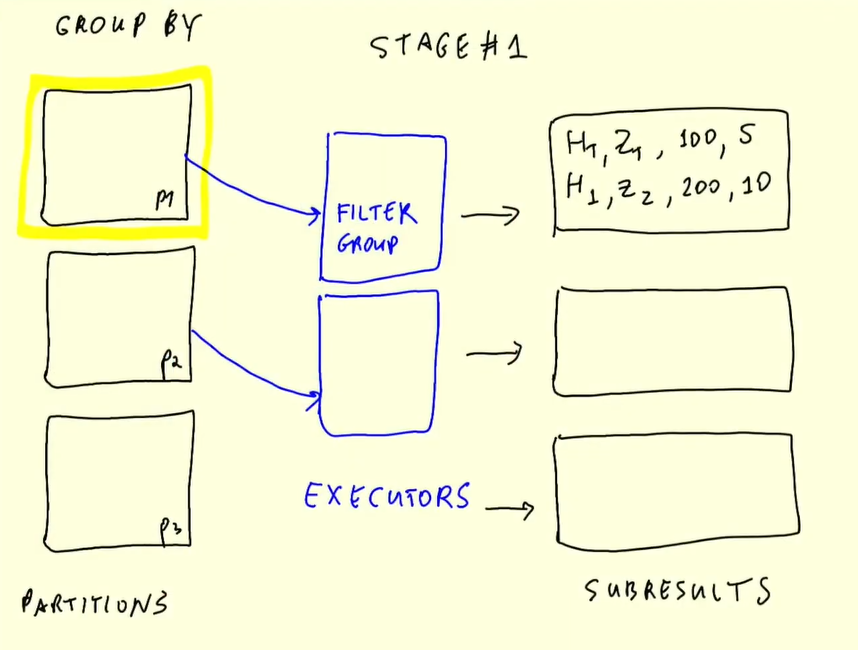

Once the initial `groupBy` is done, Spark performs a procedure called `reshuffling`.  Reshuffling shuffles records in each partition using keys (e.g. grouping columns) so that records with similar keys end up being in the same partition. It doesn't mean that records with different keys will be in a different partition, nope. Spark applies an algorithm called `external merge sort` that places all records with the same keys in the same partition. Once reshuffling is done, Spark reduces the number of records by grouping and calculating the aggregated results. 

In practice we would like to reshuffle as little data as possible because it's an expensive operation (need to move lots of data around)

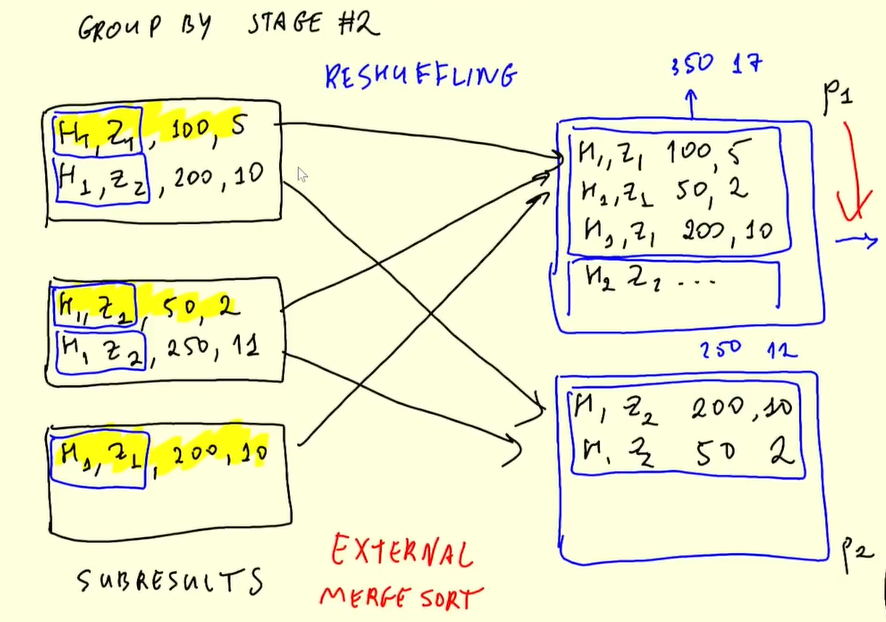

### Joins in Spark
First, we define on what columns (keys) we are going to join our Spark DataFrames. Then Spark applies `reshuffling` so that records with the same keys are located in the same partition. Once reshuffling is done, Spark applies `reduce` operation where several records with the same key turn into a single record. Besides, Spark takes into account the type of join (e.g. left, inner, ...) to define what to put into records that are not matched on keys. 

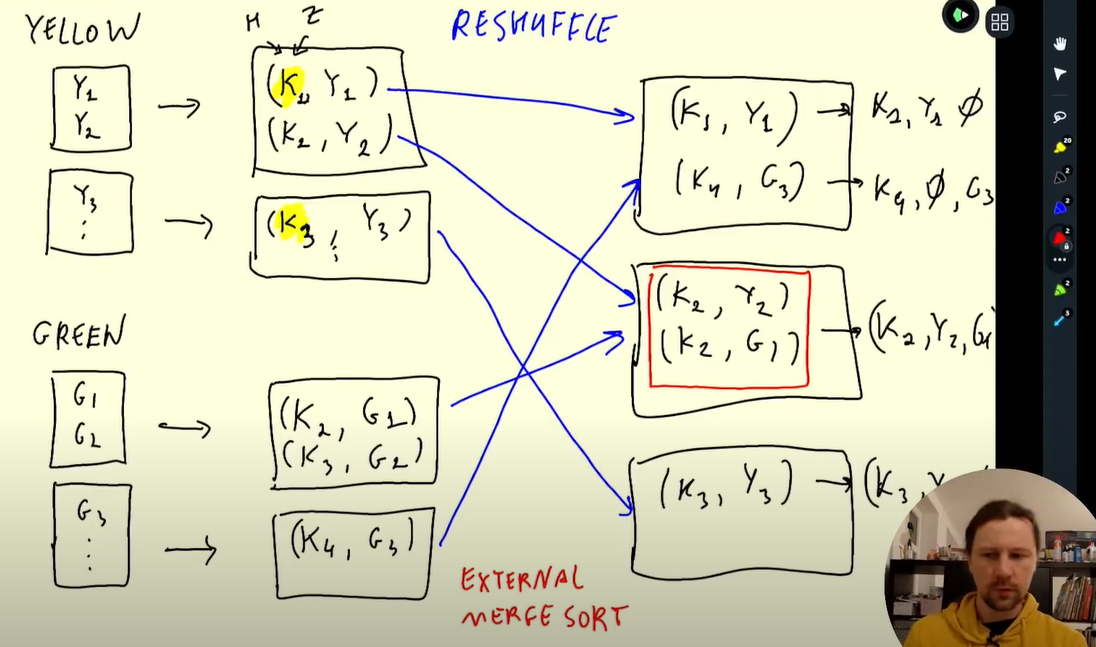


However, when one table is significantly larger or smaller than anohter one, Spark performs an operation called `broadcasting`. Each worker gets a copy of a smaller table (table broadcasting) and then join happens in memory (super fast). No need to use reshuffling.

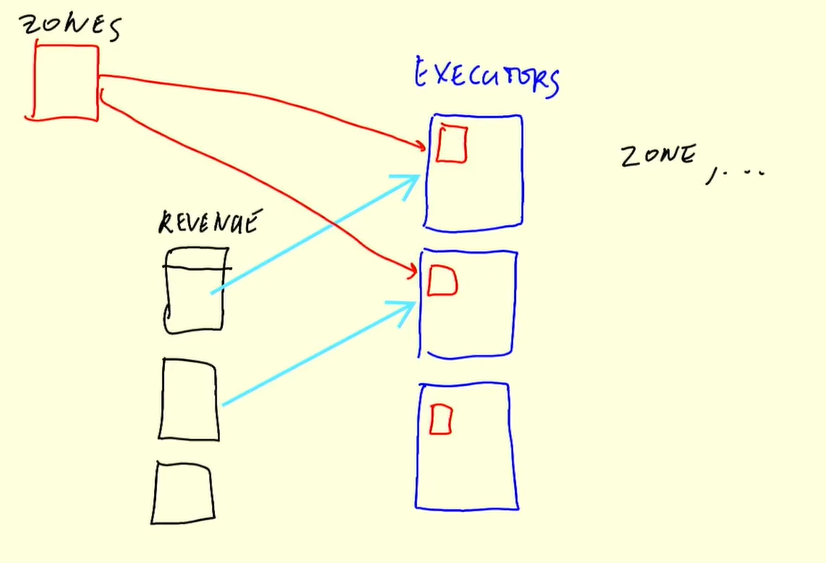

### Spark RDD - Resilient Distributed Dataset
Spark DataFrames are built on top of RDDs, another level of abstraction that provides API and set of functions so that we don't need to use RDD directly. RDD is just a distributed collection of objects and Spark DataFrame is built on top of RDD of rows (Row is a specilaobject in Spark that is used to build a DataFrame). 

**map**

Map function takes in an RDD and is applied to every element of that RDD. For every element it produces another element. 

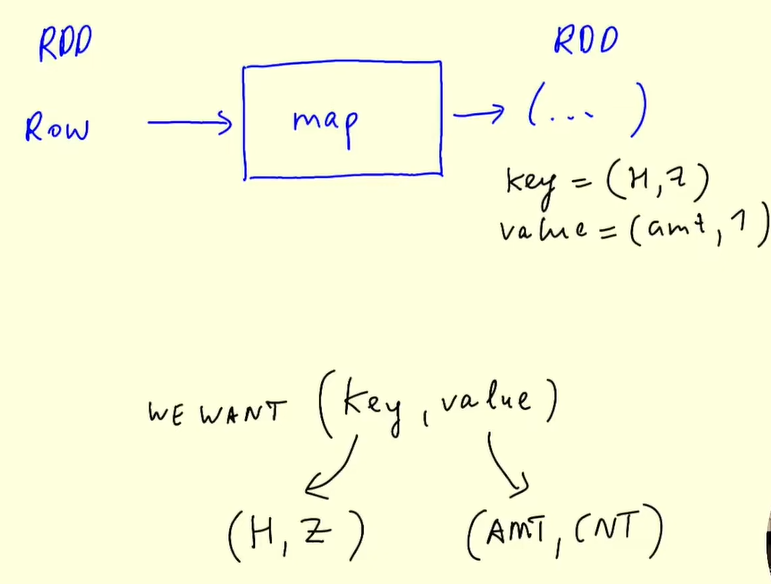


**mapPartitions**

MapPartitions takes in a RDD partition, applies a funtion to that partition and outputs another transformed partition. This function can be useful when the dataset cannot be processed on a single machine because of the size. In this case, this DataFrame is split into N partitions of smaller sizes. 

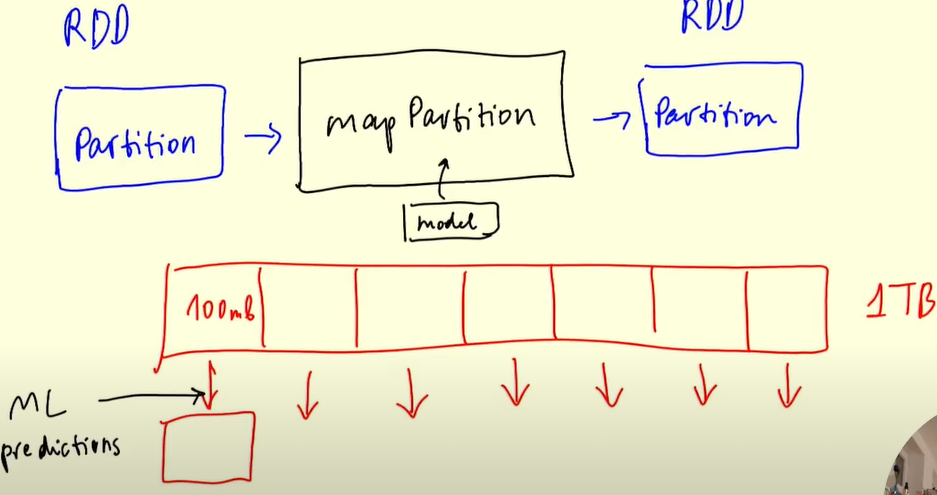